In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv")

# Convert one-hot encoded columns to a single label
label_columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
df['label'] = df[label_columns].idxmax(axis=1)

print(df[['image_id', 'label']].head())


  image_id              label
0  Train_0               scab
1  Train_1  multiple_diseases
2  Train_2            healthy
3  Train_3               rust
4  Train_4            healthy


In [2]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])
num_classes = len(le.classes_)

# Load images and labels
X = []
y = []

import cv2
import os

IMG_SIZE = 128

for i, row in df.iterrows():
    img_path = os.path.join("images", row["image_id"] + ".jpg")
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # normalize
        X.append(img)
        y.append(row["label_encoded"])

X = np.array(X)
y = to_categorical(np.array(y), num_classes=num_classes)


In [3]:
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)

Image data shape: (1821, 128, 128, 3)
Labels shape: (1821, 4)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # use stratify to balance classes
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (1456, 128, 128, 3)
Validation shape: (365, 128, 128, 3)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


d:\Celebal Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
    steps_per_epoch=len(X_train) // 32,
    verbose=1
)


d:\Celebal Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.3171 - loss: 1.3331 - val_accuracy: 0.3397 - val_loss: 1.2347
Epoch 2/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.2812 - loss: 1.2288

d:\Celebal Project\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2812 - loss: 1.2288 - val_accuracy: 0.3315 - val_loss: 1.2344
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.3738 - loss: 1.2485 - val_accuracy: 0.5041 - val_loss: 1.1902
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4375 - loss: 1.2457 - val_accuracy: 0.4384 - val_loss: 1.1890
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - accuracy: 0.4104 - loss: 1.2121 - val_accuracy: 0.4466 - val_loss: 1.1831
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4062 - loss: 1.1697 - val_accuracy: 0.4575 - val_loss: 1.1725
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - accuracy: 0.4135 - loss: 1.1881 - val_accuracy: 0.5918 - val_loss: 1.0982
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4375 - loss: 1.2265 - val_accuracy: 0.5890 - val_loss: 1.1056
Epoch 9/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.5282 - loss: 1.1196 - val_accuracy: 0.6384 - val_

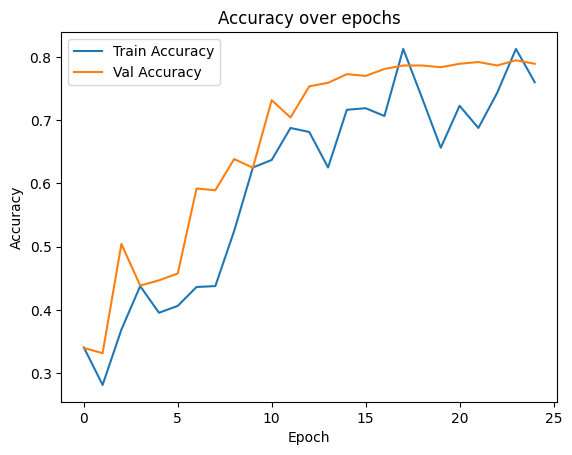

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Classification Report:
                   precision    recall  f1-score   support

          healthy       0.71      0.75      0.73       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.85      0.99      0.92       125
             scab       0.79      0.73      0.76       119

         accuracy                           0.79       365
        macro avg       0.59      0.62      0.60       365
     weighted avg       0.75      0.79      0.77       365



d:\Celebal Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Celebal Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Celebal Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


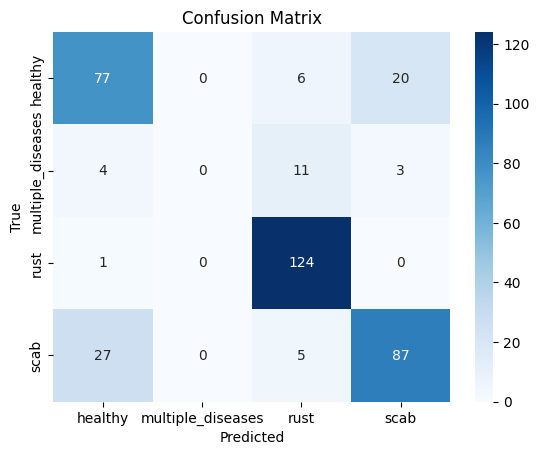

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Convert one-hot labels back to integer labels
y_train_labels = np.argmax(y_train, axis=1)


In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the unique class indices
class_indices = np.unique(y_train_labels)

# Compute the weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_indices,
    y=y_train_labels
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: 0.8813559322033898, 1: 4.986301369863014, 2: 0.7323943661971831, 3: 0.7695560253699789}


In [13]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    steps_per_epoch=len(X_train) // 32,
    class_weight=class_weights  # 👈 Add this line
)


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.7750 - loss: 0.7382 - val_accuracy: 0.7397 - val_loss: 0.6704
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6875 - loss: 0.6860 - val_accuracy: 0.7534 - val_loss: 0.6672
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 298ms/step - accuracy: 0.7417 - loss: 0.8878 - val_accuracy: 0.7918 - val_loss: 0.5949
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8125 - loss: 0.4550 - val_accuracy: 0.8000 - val_loss: 0.5862
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step - accuracy: 0.7695 - loss: 0.7194 - val_accuracy: 0.8493 - val_loss: 0.5221
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7812 - loss: 0.4448 - val_accuracy: 0.8438 - val_loss: 0.5131
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 338ms/step - accuracy: 0.8005 - loss: 0.6634 - val_accuracy: 0.8027 - val_loss: 0.5454
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7500 - loss: 1.2074 - val_accuracy: 0.

In [14]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
                   precision    recall  f1-score   support

          healthy       0.81      0.94      0.87       103
multiple_diseases       0.17      0.28      0.21        18
             rust       0.95      1.00      0.98       125
             scab       0.99      0.70      0.82       119

         accuracy                           0.85       365
        macro avg       0.73      0.73      0.72       365
     weighted avg       0.89      0.85      0.86       365



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Classification Report:
                   precision    recall  f1-score   support

          healthy       0.81      0.94      0.87       103
multiple_diseases       0.17      0.28      0.21        18
             rust       0.95      1.00      0.98       125
             scab       0.99      0.70      0.82       119

         accuracy                           0.85       365
        macro avg       0.73      0.73      0.72       365
     weighted avg       0.89      0.85      0.86       365



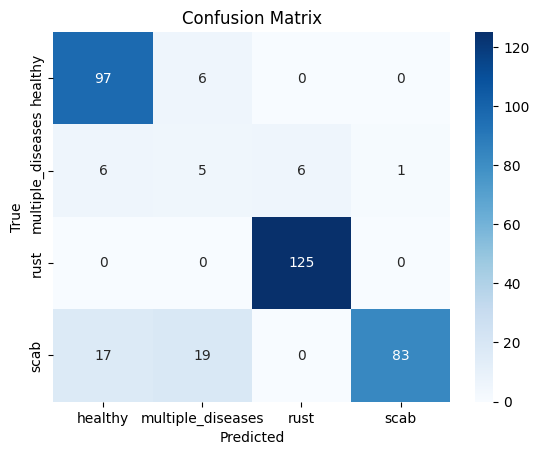

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


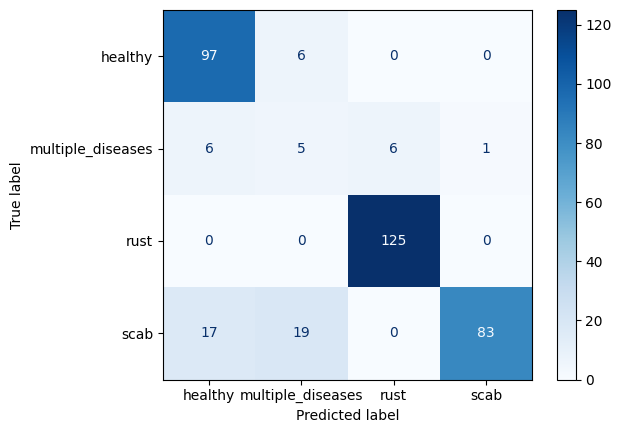

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)


cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")


In [ ]:
y_pred_prob = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_val, axis=1)
predicted_labels = le.inverse_transform(y_pred_classes)
true_labels = le.inverse_transform(y_true_classes)

for i in range(10):
    print(f"Predicted: {predicted_labels[i]}, Actual: {true_labels[i]}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Predicted: healthy, Actual: healthy
Predicted: scab, Actual: scab
Predicted: multiple_diseases, Actual: multiple_diseases
Predicted: multiple_diseases, Actual: scab
Predicted: rust, Actual: rust
Predicted: rust, Actual: rust
Predicted: rust, Actual: rust
Predicted: scab, Actual: scab
Predicted: rust, Actual: multiple_diseases
Predicted: rust, Actual: rust


Test Accuracy: 0.8493150684931506

Classification Report:
                   precision    recall  f1-score   support

          healthy       0.81      0.94      0.87       103
multiple_diseases       0.17      0.28      0.21        18
             rust       0.95      1.00      0.98       125
             scab       0.99      0.70      0.82       119

         accuracy                           0.85       365
        macro avg       0.73      0.73      0.72       365
     weighted avg       0.89      0.85      0.86       365



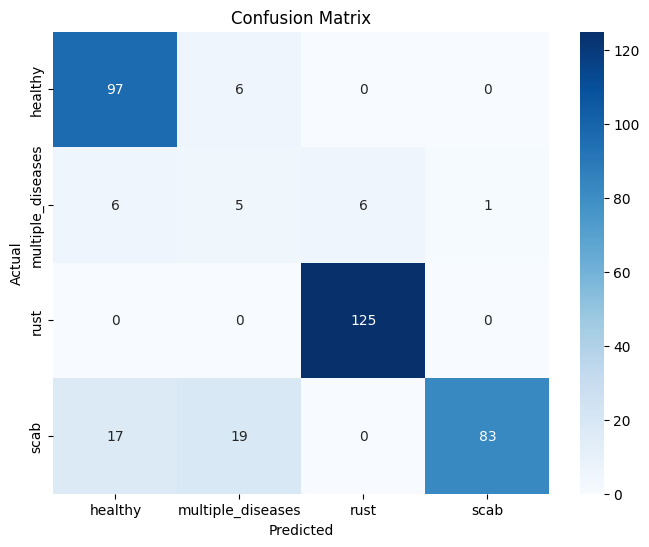

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Test Accuracy:", accuracy_score(true_labels, predicted_labels))
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels, labels=le.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os

def sort_key(filename):
    return int(filename.split('_')[1].split('.')[0])

test_folder = "test images/"
filenames = sorted(
    [f for f in os.listdir(test_folder) if f.endswith(".jpg")],
    key=sort_key
)


print(filenames[:10])  


['Test_0.jpg', 'Test_1.jpg', 'Test_2.jpg', 'Test_3.jpg', 'Test_4.jpg', 'Test_5.jpg', 'Test_6.jpg', 'Test_7.jpg', 'Test_8.jpg', 'Test_9.jpg']


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 128
predictions = []

for filename in filenames:  
    path = os.path.join(test_folder, filename)
    
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred_prob = model.predict(img)
    pred_class = np.argmax(pred_prob, axis=1)
    pred_label = le.inverse_transform(pred_class)[0]

    predictions.append((filename.replace(".jpg", ""), pred_label))
    print(f"{filename}: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Test_0.jpg: rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Test_1.jpg: rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test_2.jpg: scab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Test_3.jpg: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Test_4.jpg: rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test_5.jpg: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test_6.jpg: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Test_7.jpg: scab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test_8.jpg: scab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Test_9.jpg: rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test_10.jpg: rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test_11.jpg: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test_12.jpg: scab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test_13.jpg: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test_14.jpg: rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test_15.jpg: rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Test_16.jpg: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
T

In [21]:
import pandas as pd

submission_df = pd.DataFrame(predictions, columns=["image_id", "label"])
submission_df.to_csv("cnn_submission.csv", index=False)
print("Saved as cnn_submission.csv")


Saved as cnn_submission.csv


In [ ]:

model.save("plant_disease_cnn_model_final.h5")


In [23]:
import pickle

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


In [ ]:

model = load_model("plant_disease_cnn_model_final.h5")  


with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)


In [ ]:
def preprocess_image(img_path, target_size=(128, 128)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array


In [51]:
def predict_single_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    predicted_label = le.classes_[predicted_class]
    return predicted_label

In [ ]:

image_path = "test images/Test_170.jpg"


result = predict_single_image(image_path)
print(f"Prediction for '{image_path}': {result}")
print("Prediction probabilities:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Prediction for 'test images/Test_170.jpg': multiple_diseases
Prediction probabilities: [[0.97449696 0.02224649 0.00218056 0.00107597]]


In [ ]:

image_path = "images/Train_19.jpg"


result = predict_single_image(image_path)
print(f"Prediction for '{image_path}': {result}")
print("Prediction probabilities:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for 'images/Train_19.jpg': healthy
Prediction probabilities: [[0.97449696 0.02224649 0.00218056 0.00107597]]


In [81]:
def predict_with_confidence(image_path):
    img = preprocess_image(image_path)
    pred_probs = model.predict(img)[0]
    
    for cls, prob in zip(le.classes_, pred_probs):
        print(f"{cls}: {prob:.2f}")
    
    predicted_class = le.classes_[np.argmax(pred_probs)]
    print("Predicted Class:", predicted_class)


In [92]:
predict_with_confidence("test images/Test_2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
healthy: 0.00
multiple_diseases: 0.45
rust: 0.00
scab: 0.55
Predicted Class: scab


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 128  

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  
    img = np.expand_dims(img, axis=0)  
    return img


In [ ]:
image_path = "images/Train_9.jpg"
img = preprocess_image(image_path)

prediction = model.predict(img)  
predicted_class_index = np.argmax(prediction)
predicted_label = le.inverse_transform([predicted_class_index])[0]

print("Predicted Label:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: multiple_diseases
